In [4]:
import sys
import json
from collections import namedtuple, defaultdict
from pathlib import Path
from tqdm import tqdm

# add parent folder to the path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd; tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from utils.load_gfa import load_gfa

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import AlignIO

In [5]:
# PATH_GFAS: 
PATHS_GFAS= [
"../HLA-zoo-pangeblocks/*/gfa-unchop/*/*/*.gfa",
"../HLA-zoo-PanPA/*/*.gfa",
# "../HLA-zoo-makeprg/*/*.gfa",  
"../HLA-zoo-pggb/*/*.gfa",
"../HLA-zoo-vg/*/*.gfa"
] 

PATH_SAVE=Path("../HLA-zoo-common-substrings")
PATH_SAVE.mkdir(exist_ok=True, parents=True)

In [6]:
def get_id_plot(path_gfa):

    if "pangeblocks" in path_gfa:
        # loss function info
        *_,mafft,_,loss_func, pen_len,_ = path_gfa.split("/")
        
        op_ep = mafft.split("-mafft.")[-1]
        p, ml = pen_len.split("-")
        
        p=p.replace("penalization","p")
        ml=ml.replace("min_len","l")
        loss_func=loss_func[0]
        return "-".join(["pangeblocks","mafft",op_ep,loss_func,p,ml])
    
    if "pggb" in path_gfa:
        return "pggb"

    if "PanPA" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["panpa","mafft",op_ep])

    if "vg" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["vg","mafft",op_ep])

    if "makeprg" in path_gfa:
        *_, mafft, _ = path_gfa.split("/")
        op_ep = mafft.split("-mafft.")[-1]
        return "-".join(["makeprg","mafft",op_ep])

def get_seqsid(path_gfa):

    if "pggb" in path_gfa:
        return Path(path_gfa).stem.split(".")[0]
    else:
        return Path(path_gfa).stem

In [7]:
path_gfa= list(Path().rglob(PATHS_GFAS[3]))[0]
path_gfa, get_seqsid(str(path_gfa))

(PosixPath('../HLA-zoo-vg/output-HLA-zoo-mafft.op1.53-ep0/MICA-100507436.gfa'),
 'MICA-100507436')

In [8]:
def get_nodes_depth(path_gfa, return_common_substring=False):
    "return a dictionary with 'node depth' as values (number of paths using the node) and 'nodeid' as keys"
    nodes, edges, paths=load_gfa(path_gfa, return_nodes_path=True)
    nodes_depth = defaultdict(int)

    for pathid, path_nodes in paths.items(): 
        for node in path_nodes:
            nodes_depth[node] +=1

    if return_common_substring is True:

        n_paths=len(paths)

        # take the last path (could be any path) and enumerate its nodes
        nodeid2order= {nodeid: order for order,nodeid in enumerate(path_nodes) }
        
        # filter nodes with node_depth=n_paths
        nodes_common_subpath=[ nodeid for nodeid, depth in nodes_depth.items() if  depth==n_paths ]
        
        # sort nodes 
        nodes_common_subpath=sorted(nodes_common_subpath, key=lambda nodeid: nodeid2order[nodeid])
        common_substring="".join([nodes[nodeid]["label"] for nodeid in nodes_common_subpath])
        
        return nodes_depth, common_substring

    return nodes_depth

In [9]:
nodes_depth , common_substring = get_nodes_depth(path_gfa, return_common_substring=True)

In [10]:
nodes, edges, paths=load_gfa(path_gfa, return_nodes_path=True)

In [11]:
# Collect information for all graphs
InfoGFA=namedtuple("InfoGFA",["path_gfa","id_plot", "seqsid","common_substring"])

list_info=[]
# 1. For each graph generated from that set of sequences, extract the substring that is common to all paths
for path_gfas in PATHS_GFAS:
    
    desctqdm = str(path_gfas).split("/")[1]
    list_gfas = list(Path().rglob(path_gfas))
    
    for path_gfa in tqdm(list_gfas, desc=f"Working on {desctqdm}"):
        path_gfa=str(path_gfa)
        id_plot = get_id_plot(path_gfa)
        seqsid  = get_seqsid(path_gfa)

        nodes_depth, common_substring = get_nodes_depth(path_gfa, return_common_substring=True)

        list_info.append(
            InfoGFA(path_gfa, id_plot, seqsid, common_substring)
        )
        

Working on HLA-zoo-vg: 100%|██████████| 84/84 [00:00<00:00, 174.38it/s]


In [12]:
data_gfas = pd.DataFrame(list_info)

In [13]:
# Now I need to filter by seqsid and save a fasta file with all sequences involved 
list_seqsid = list(set([d.seqsid for d in list_info]))
list_seqsid.sort()

for seqsid in list_seqsid:
    
    # list to save all common substrings from all GFAs generated from the same set of sequences 'seqsid'
    records_seqsid = []
    gfas_seqsid = list(filter(lambda infogfa: infogfa.seqsid == seqsid, list_info))

    for infogfa in tqdm(gfas_seqsid, desc=f"Working on {seqsid}"):
        
        record = SeqRecord(
                        Seq(infogfa.common_substring),
                        id=infogfa.id_plot,
                        name=seqsid,
                        description=f"common substring {seqsid}-{infogfa.id_plot}",
                    )
        records_seqsid.append(record)
    
    SeqIO.write(records_seqsid, PATH_SAVE.joinpath(f"{seqsid}.fa") , "fasta")

Working on V-352962: 100%|██████████| 40/40 [00:00<00:00, 92233.18it/s]


## Now I run mafft over all of them

## ...

In [14]:
def hamming_distance(str1, str2):
    "return hamming distance normalized by the length of the strings"
    assert len(str1)==len(str2), "input strings are not of the same length"
    return sum([s1!=s2 for s1,s2 in zip(str1,str2)]) / len(str1)

In [15]:
## And now I compute the alignments and compute the hamming distance of all pairs
list_msas = list(Path("/data/pangeblocks-experiments/HLA-zoo-common-substrings/mafft.op1.53-ep0/").rglob("*.fa"))
seqsid2msa={path_msa.stem: path_msa for path_msa in list_msas}
list_msas=list(list_msas)
list_msas.sort()
iter_seqsid = iter(list_msas)

In [18]:
align=AlignIO.read(path_msa, "fasta")
for record in align:
    print( len(record.seq)-  len(record.seq.replace("-","")))

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
3
3
3


In [17]:
path_msa = next(iter_seqsid); seqsid=path_msa.stem

seqsid="H-3136"
path_msa = seqsid2msa[seqsid]
print(seqsid, path_msa)

H-3136 /data/pangeblocks-experiments/HLA-zoo-common-substrings/mafft.op1.53-ep0/H-3136.fa


In [ ]:
# load MSA and compute pairwise hamming distances
align=AlignIO.read(path_msa, "fasta")
N = len(align)
distance_matrix = np.zeros((N,N))
keys=[]
for k1, record1 in enumerate(align):
    keys.append(record1.id)
    for k2, record2 in enumerate(align): 
        if k1 != k2: 
            distance_matrix[k1,k2] = hamming_distance(str(record1.seq), str(record2.seq))

Text(0.5, 1.05, 'The common susbstring is obtained as the substring that is shared for all the paths in a graph')

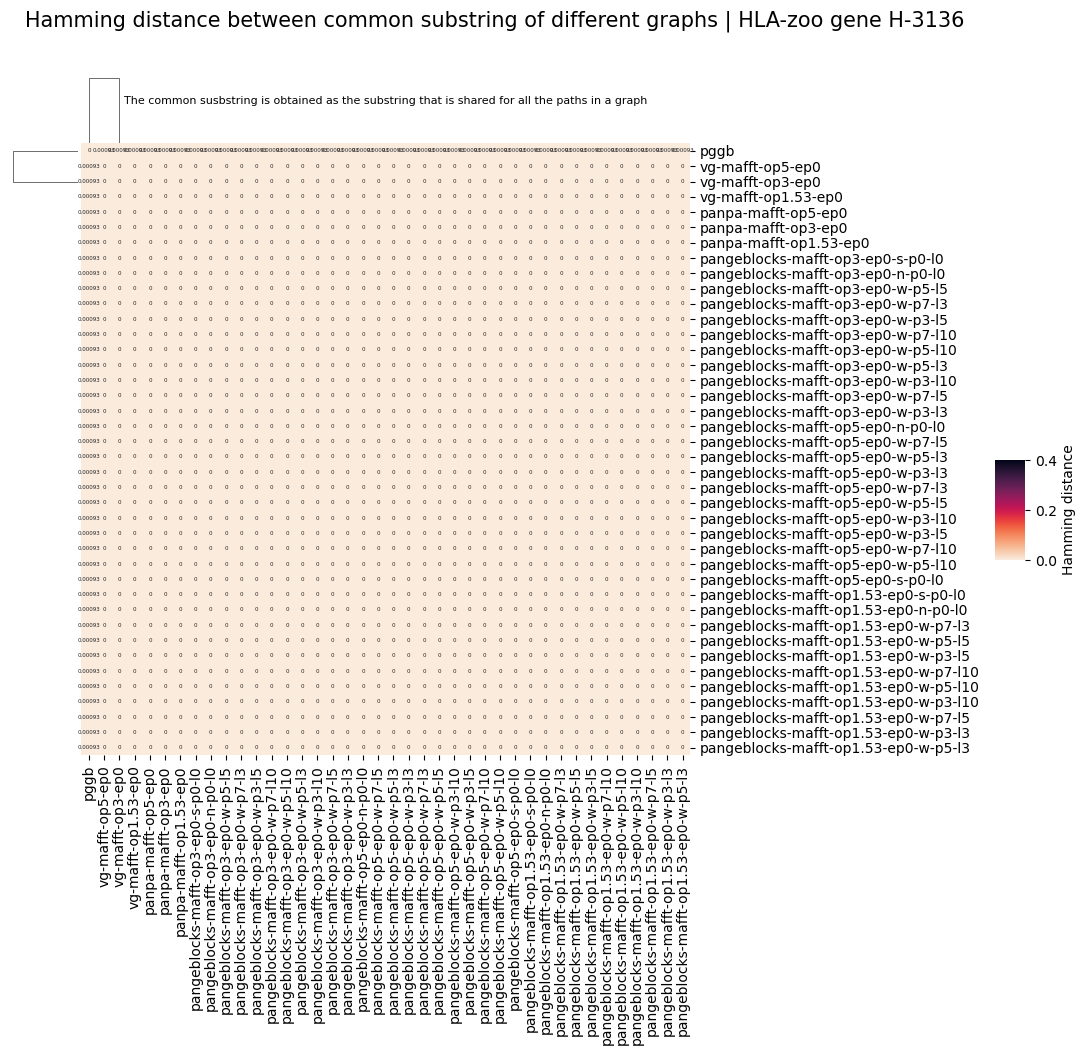

In [ ]:
import numpy as np 
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc 

linkage = hc.linkage(sp.distance.squareform(distance_matrix), method='average')

g=sns.clustermap(
                pd.DataFrame(distance_matrix, index=keys, columns=keys), 
                row_linkage=linkage, col_linkage=linkage, 
                annot=True, annot_kws={"size": 4},
                cmap="rocket_r",
                vmin=0, vmax=0.4, figsize=(10,10), 
                cbar_pos=(1, 0.5, .03, .1),
                dendrogram_ratio=(.1, .1),
                cbar_kws={"label": "Hamming Distance"}
                )

g.ax_cbar.set_ylabel("Hamming distance",)
g.fig.suptitle(f"Hamming distance between common subsequence of different graphs | HLA-zoo gene {seqsid}",y=1.05, size=15)
g.ax_heatmap.set_title(f"The common susbstring is obtained as the substring that is shared for all the paths in a graph", size=8, y=1.05)